# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

We'll also upgrade TensorFlow to ensure we have a version that is compatible with the latest version of the dataset.

In [ ]:
#The new version of dataset is only available in the tfds-nightly package. 
%pip --no-cache-dir install tfds-nightly --user 
!pip install tensorflow --upgrade --user

     |████████████████████████████████| 5.3MB 4.6MB/s eta 0:00:01
     |████████████████████████████████| 163kB 44.1MB/s eta 0:00:01
     |████████████████████████████████| 307kB 35.2MB/s eta 0:00:01
     |████████████████████████████████| 102kB 36.6MB/s ta 0:00:01
     |████████████████████████████████| 143kB 43.9MB/s eta 0:00:01
ERROR: tensorflow-metadata 0.14.0 has requirement protobuf<4,>=3.7, but you'll have protobuf 4.23.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 588.3MB 23kB/s s eta 0:00:01     |████████████▋                   | 232.6MB 47.7MB/s eta 0:00:08
     |████████████████████████████████| 133kB 30.8MB/s eta 0:00:01
     |████████████████████████████████| 1.1MB 24.4MB/s eta 0:00:01
     |████████████████████████████████| 2.4MB 42.3MB/s eta 0:00:01
     |██████████████████

     |███████████████                 | 2.8MB 31.1MB/s eta 0:00:01

     |████████████████████████████▉   | 5.4MB 31.1MB/s eta 0:00:01

     |████████████████████████████████| 6.0MB 31.1MB/s eta 0:00:01
     |████████████████████████████████| 5.1MB 44.8MB/s eta 0:00:01
     |████████████████████████████████| 15.7MB 20.9MB/s eta 0:00:01    |███████▋                        | 3.7MB 20.9MB/s eta 0:00:01
     |████████████████████████████████| 1.7MB 26.7MB/s eta 0:00:01
     |████████████████████████████████| 440kB 31.6MB/s eta 0:00:01
     |████████████████████████████████| 788kB 40.4MB/s eta 0:00:01
     |████████████████████████████████| 4.9MB 28.1MB/s eta 0:00:01
     |████████████████████████████████| 235kB 38.6MB/s eta 0:00:01
     |████████████████████████████████| 184kB 41.6MB/s eta 0:00:01
     |████████████████████████████████| 184kB 32.1MB/s eta 0:00:01
     |████████████████████████████████| 153kB 27.4MB/s eta 0:00:01
     |████████████████████████████████| 92kB 11.1MB/s eta 0:00:01
  Found existing installation: protobuf 4.23.0
    Uninstalling protobuf-4.23.0:
      Successfully uninstalled protobuf-4.23.0
  C

After the above installations have finished **be sure to restart the kernel**. You can do this by going to **Kernel > Restart**.

In [1]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Ignore some warnings that are not relevant (you can remove this if you prefer)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# TODO: Make all other necessary imports.
import matplotlib.pyplot as plt
import json
import tensorflow_hub as hub
import numpy as np
from PIL import Image

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
# Some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

In [4]:
# Load the Oxford Flowers-102 dataset
(train_dataset, test_dataset, validation_dataset), dataset_info = tfds.load(
    'oxford_flowers102',
    split=['train', 'test', 'validation'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

# Function to normalize and resize images
def preprocess_image(image, label):
    # Normalize pixels to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Resize images to 224x224 pixels
    image = tf.image.resize(image, (224, 224))
    return image, label

# Apply preprocessing to the datasets
train_dataset = train_dataset.map(preprocess_image)
test_dataset = test_dataset.map(preprocess_image)
validation_dataset = validation_dataset.map(preprocess_image)

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Explore the Dataset

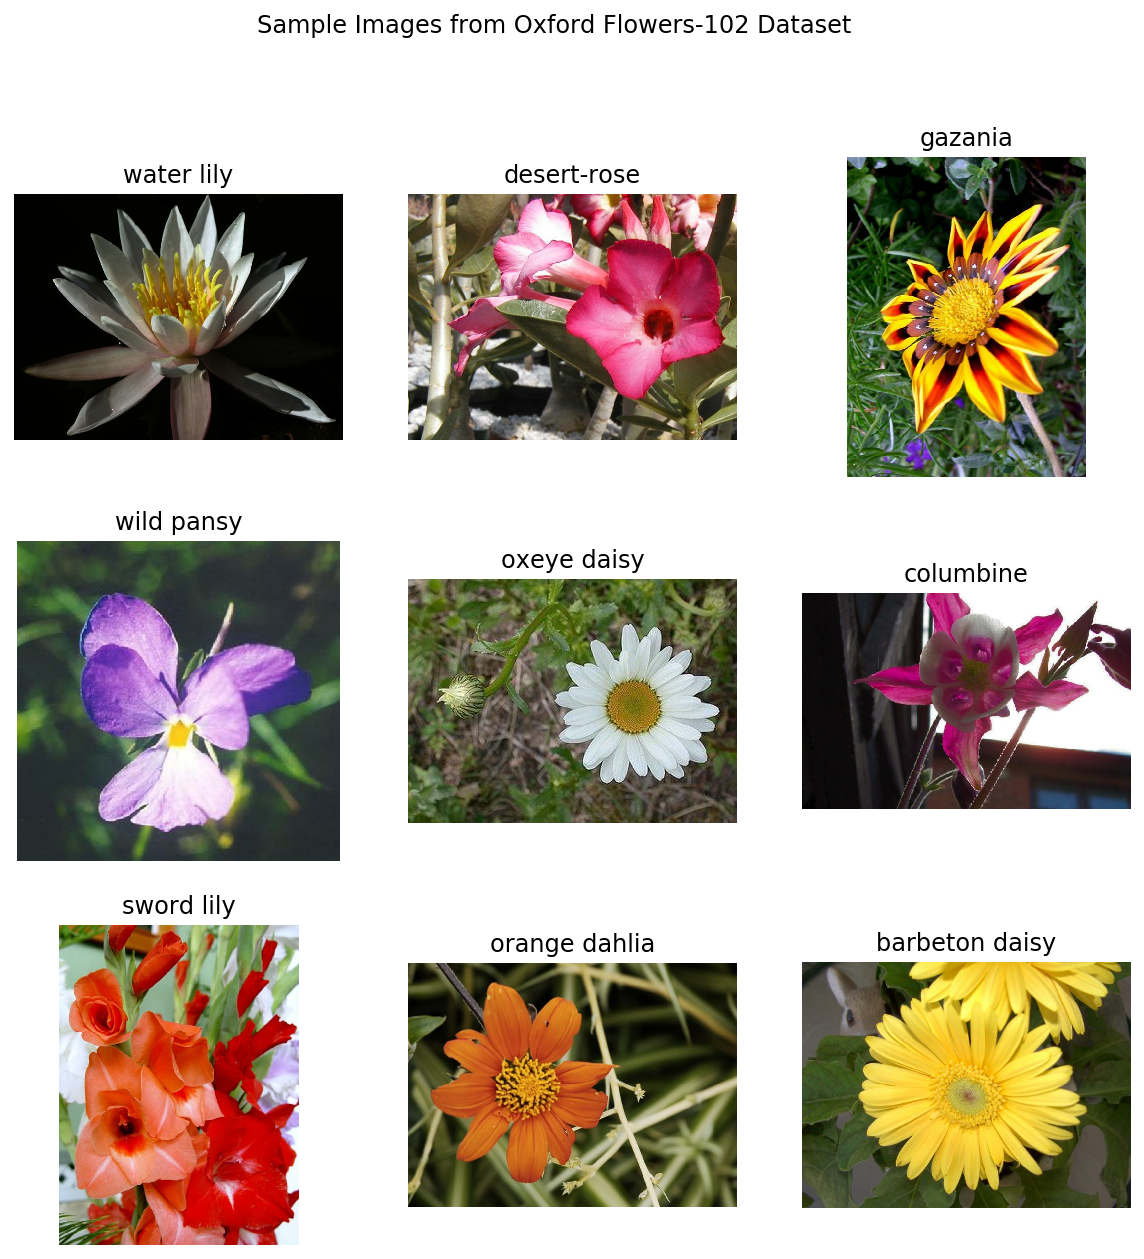

In [5]:
# Load the Oxford Flowers-102 dataset
dataset, dataset_info = tfds.load('oxford_flowers102', split='train', shuffle_files=True, with_info=True)

# Get the number of classes in the dataset
num_classes = dataset_info.features['label'].num_classes

# Get the class names
class_names = dataset_info.features['label'].names

# Display some sample images from the dataset
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Sample Images from Oxford Flowers-102 Dataset')

for i, data in enumerate(dataset.take(9)):
    image = data['image']
    label = data['label']
    row = i // 3
    col = i % 3
    axs[row, col].imshow(image)
    axs[row, col].set_title(class_names[label.numpy()])
    axs[row, col].axis('off')

plt.show()

In [ ]:
!pip install jinja2

In [6]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
# TODO: Print the shape and corresponding label of 3 images in the training set.
counter = 0
for data in dataset.take(3):
    image = data['image']
    label = data['label']
    print(f"Image shape: {image.shape}, Label: {class_names[label.numpy()]}")
    counter += 1

    if counter == 3:
        break

Image shape: (500, 667, 3), Label: water lily
Image shape: (500, 666, 3), Label: desert-rose
Image shape: (670, 500, 3), Label: gazania


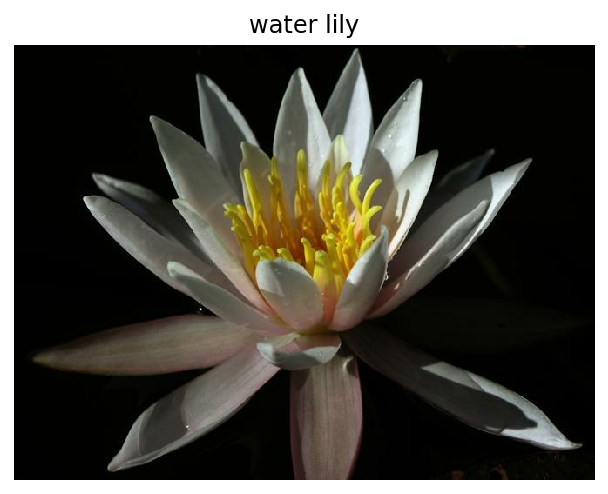

In [7]:
# TODO: Plot 1 image from the training set. 
# Set the title of the plot to the corresponding image label.
# Plot one image from the training set
for data in dataset.take(1):
    image = data['image']
    label = data['label']
plt.imshow(image)
plt.title(class_names[label])
plt.axis('off')
plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [8]:
# Read the label mapping from the JSON file
with open('label_map.json', 'r') as file:
    label_map = json.load(file)

# Print the label mapping
print(label_map)


{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

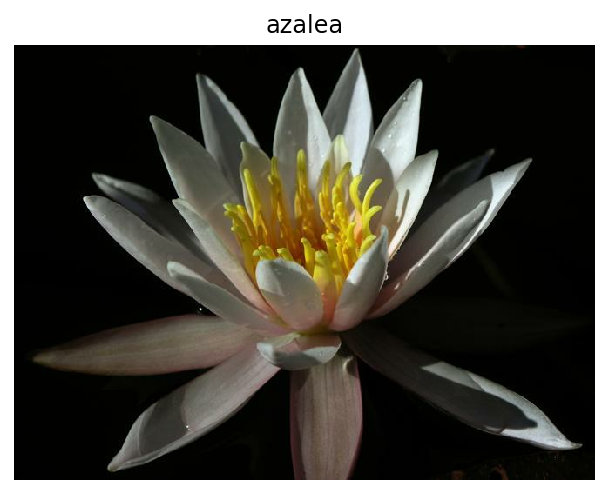

In [9]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
# Plot one image from the training set
for data in dataset.take(1):
    image = data['image']
    label = data['label']

plt.imshow(image)
plt.title(label_map[str(label.numpy())])
plt.axis('off')
plt.show()

## Create Pipeline

In [10]:
# Define the batch size and image size
batch_size = 32
image_size = (224, 224)

# Load the Oxford Flowers-102 dataset
train_dataset, test_dataset, validation_dataset = tfds.load(
    'oxford_flowers102',
    split=['train', 'test', 'validation'],
    shuffle_files=True,
    as_supervised=True
)

# Function to preprocess the images
def preprocess_image(image, label):
    # Normalize pixels to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Resize images to the desired size
    image = tf.image.resize(image, image_size)
    return image, label

# Apply preprocessing and batching to the train, test, and validation datasets
train_dataset = train_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [36]:
# Load the MobileNet pre-trained network from TensorFlow Hub
mobilenet_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                   input_shape=(224, 224, 3),
                   trainable=False)
])

# Define a new, untrained feed-forward network as a classifier

model = tf.keras.Sequential([
    mobilenet_model,
    tf.keras.layers.Dense(102, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the classifier
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

SyntaxError: invalid syntax (<ipython-input-36-2e3efcdbfe40>, line 10)

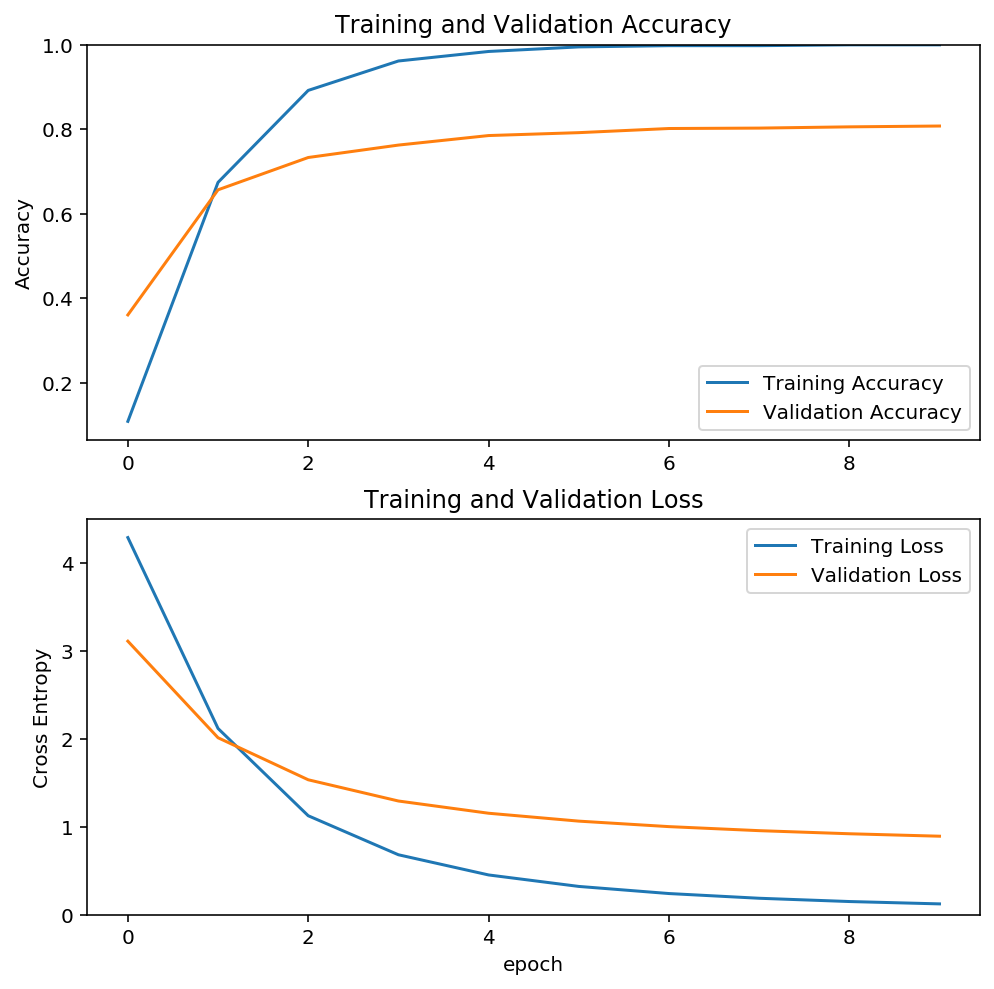

In [12]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [13]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

193/193 [==============================] - 128s 661ms/step - loss: 1.0203 - accuracy: 0.7718
Test Loss: 1.0203
Test Accuracy: 0.7718


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [14]:
# TODO: Save your trained model as a Keras model
model_filepath = './my_model.h5'

# model.save(saved_keras_model_filepath)
model.save(model_filepath)

## Load the Keras Model

Load the Keras model you saved above.

In [15]:
# TODO: Load the Keras model
reloaded_keras_model = tf.keras.models.load_model(model_filepath, custom_objects={'KerasLayer':hub.KerasLayer})

reloaded_keras_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [29]:
# TODO: Create the process_image function
def preprocess_image(image, label):
    # Normalize pixels to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Resize images to the desired size
    image = tf.image.resize(image, image_size)
    return image, label

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

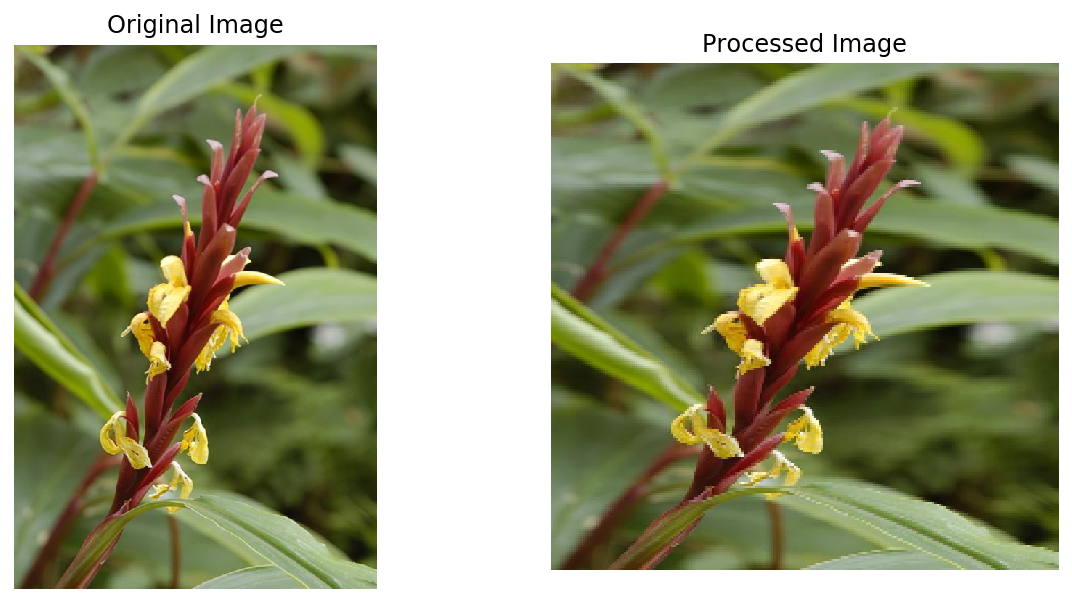

In [17]:
# Load and preprocess the test image
image_path = './test_images/cautleya_spicata.jpg'
image = Image.open(image_path)
processed_image, _ = preprocess_image(image, None)

# Plot the original image and the processed image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(processed_image)
axes[1].set_title('Processed Image')
axes[1].axis('off')

plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [32]:
def predict(image_path, model, top_k):
    # Load and preprocess the image
    image = Image.open(image_path)
    processed_image, _ = preprocess_image(image, None)
    processed_image = np.expand_dims(processed_image, axis=0)

    # Predict the probabilities
    predictions = model.predict(processed_image)
    top_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_indices_adjusted = [index + 1 for index in top_indices]  # Adjust indices by adding 1
    top_probabilities = predictions[0][top_indices]

    # Get the class labels
    label_map = json.load(open('label_map.json'))
    classes = [label_map[str(index)] for index in top_indices_adjusted]

    return top_probabilities, classes

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 [==============================] - 0s 45ms/step


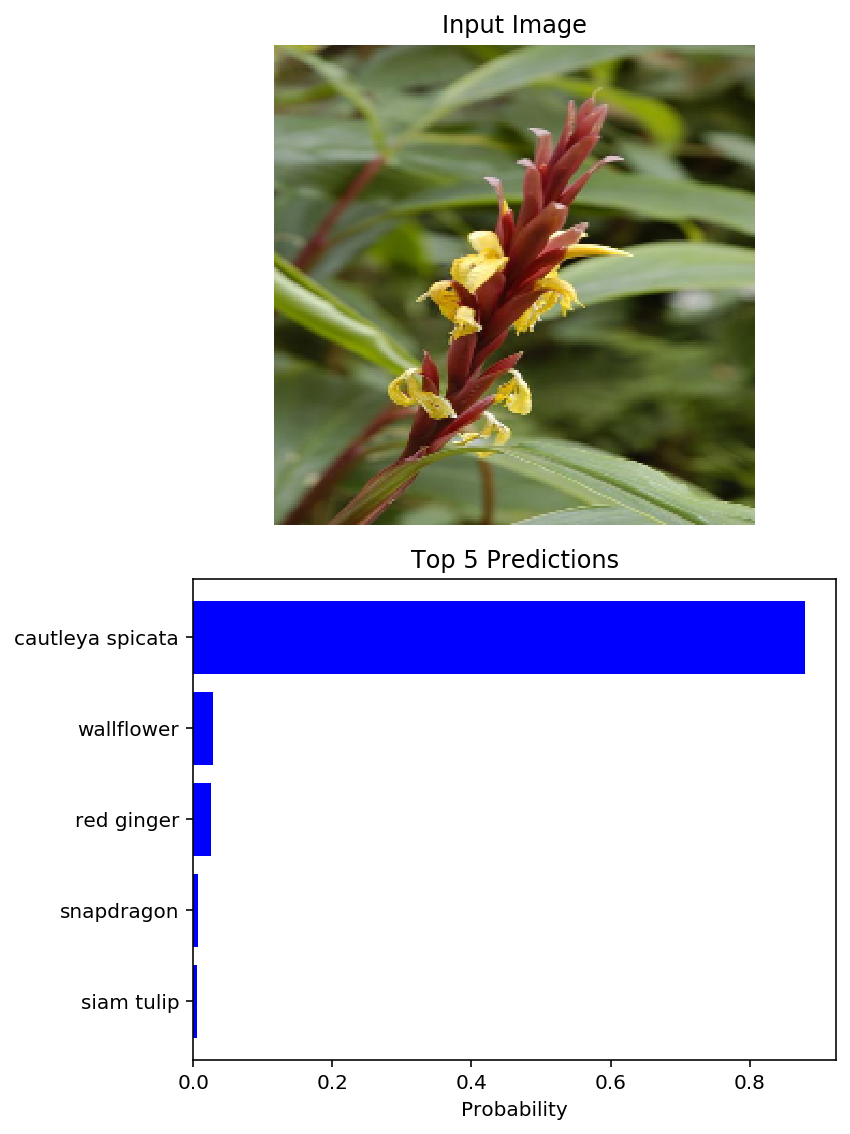

1/1 [==============================] - 0s 44ms/step


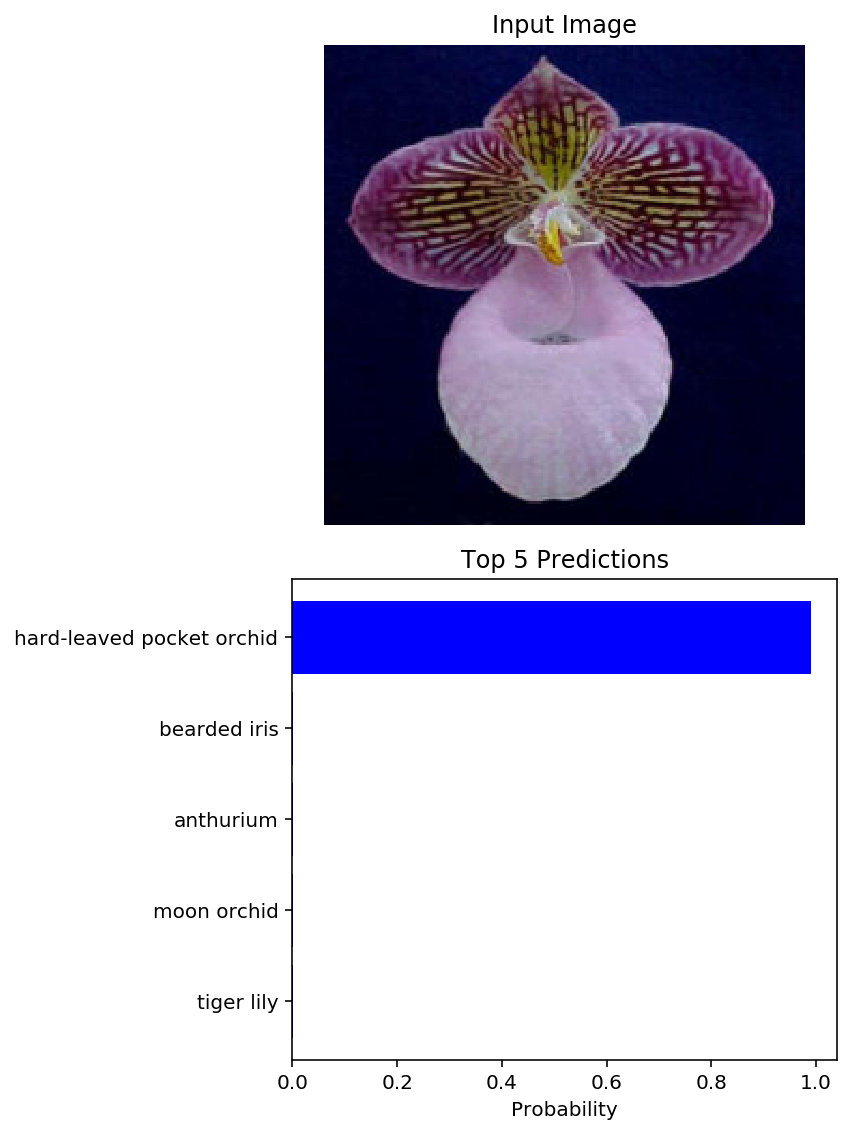

1/1 [==============================] - 0s 48ms/step


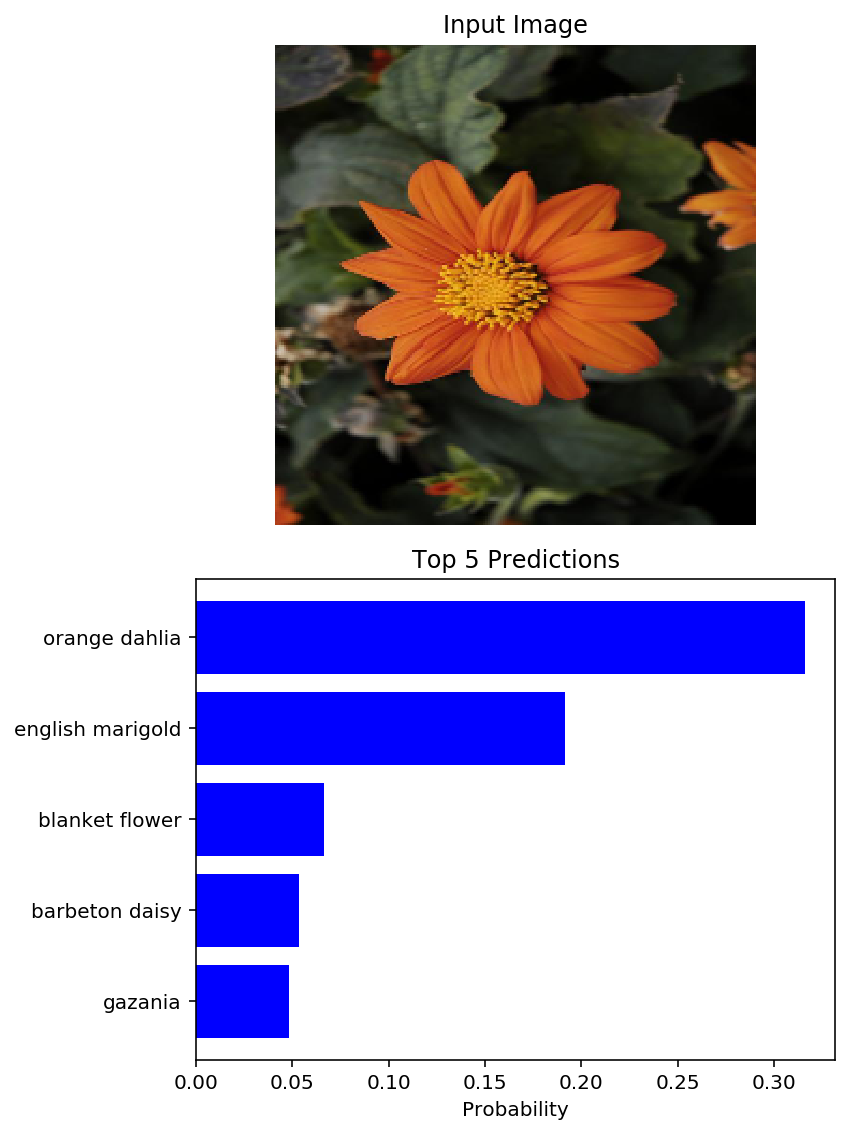

1/1 [==============================] - 0s 46ms/step


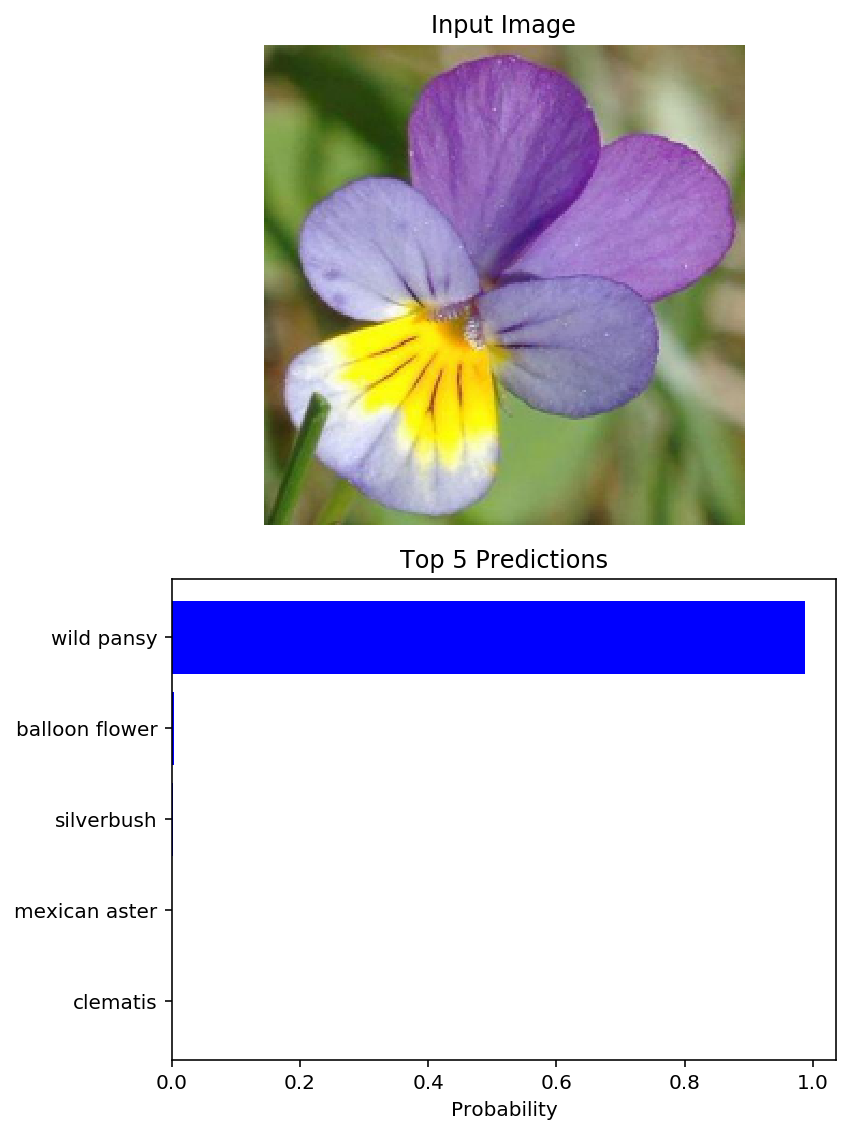

In [21]:
image_paths = ['./test_images/cautleya_spicata.jpg',
               './test_images/hard-leaved_pocket_orchid.jpg',
               './test_images/orange_dahlia.jpg',
               './test_images/wild_pansy.jpg']

for image_path in image_paths:
    # Predict the probabilities and classes
    probs, classes = predict(image_path, model, top_k=5)
    
    # Load and preprocess the image
    image = Image.open(image_path)
    processed_image, _ = preprocess_image(image, None)

    # Plot the image and the probabilities
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 8), nrows=2)
    ax1.imshow(processed_image)
    ax1.axis('off')
    ax1.set_title('Input Image')

    # Create a horizontal bar plot for the probabilities
    y_pos = np.arange(len(classes))
    ax2.barh(y_pos, probs, align='center', color='blue')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes)
    ax2.invert_yaxis()
    ax2.set_xlabel('Probability')
    ax2.set_title('Top 5 Predictions')

    plt.tight_layout()
    plt.show()

In [40]:
!pip uninstall -y markupsafe
!pip install markupsafe
!!jupyter nbconvert *.ipynb

Uninstalling MarkupSafe-2.1.2:
  Successfully uninstalled MarkupSafe-2.1.2


['[NbConvertApp] Converting notebook Project_Image_Classifier_Project.ipynb to html',
 '[NbConvertApp] Writing 4259657 bytes to Project_Image_Classifier_Project.html']

In [39]:
!python predict.py ./test_images/orange_dahlia.jpg my_model.h5 --category_names label_map.json

2023-05-16 10:01:28.468250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 10:01:28.600645: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-16 10:01:28.600714: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-16 10:01:29.531956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-